# Rapid adiabatic passage in a 2-level system
This notebook illustrates using the `toy_systems` package to set up a Hamiltonian and decay matrix for a two level system and then performing rapid adiabatic passage on the system. The main difference between this notebook and the notebook on Rabi oscillations (*Rabi oscillations in 2-level system.ipynb*) is that the Rabi rate and detuning of the of the drive field will be time-dependent. Thus this notebook primarily serves to illustrate how to deal with a time-dependent Hamiltonian.

## Imports
Start by importing the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.decays import Decay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers

## Define states
We start by defining the two states of the system: the ground state $|g\rangle$ and the excited $|e\rangle$, which we will later set to have a decay path to $|g\rangle$:

In [2]:
g = BasisState(qn=ToyQuantumNumbers(label="g"))
e = BasisState(qn=ToyQuantumNumbers(label="e"))

# Print the states as a check
print(f"|g> = {g}")
print(f"|e> = {e}")

# Check that the states are orthogonal by taking inner product
print(f"<e|g> = {e @ g}")

|g> = |g>
|e> = |e>
<e|g> = 0


## Define basis
We use the two orthogonal states to define a basis as shown below. The indexing of the matrix and vector representations of operators is determined by the order of the states when generating the state

In [3]:
basis = Basis((g,e))
basis.print_basis()

|0> = |g>
|1> = |e>


## Define energies
I'm going to define the system in the rotating frame so that the Hamiltonian doesn't have any quickly rotating terms of the form $e^{i\omega t}$. The detuning between the driving field and the natural frequency of the system is taken to be $\Delta(t)$ (time-varying), so I can set the energies of the two states to be $E_g = -\Delta/2$ and $E_e = \Delta/2$.

Note: the time dependence will be multiplied by the value of $\Delta$ when time-evolving the Hamiltonian.

In [19]:
Δ = Symbol('Delta') # Using sympy to generate a symbolic Hamiltonian first (to make a "Δ" type "\Delta", then press tab)
E_g = ToyEnergy(g, g, -Δ/2, time_dep = "t") # Note the linear time-dependence
E_e = ToyEnergy(e, e, +Δ/2, time_dep = "t")

### Define coupling
I'm taking the strength of the driving field to vary as a Gaussian over time. This time dependence of the drive field may result in the probability of state transfer durin RAP being slightly different from 

In [5]:
Ω = Symbol('Omega') 
coupling = ToyCoupling(g, e, Ω, time_dep = "exp(-t**2/(2*sigma**2))", time_args={"sigma": 1})

## Define Hamiltonian
Now that we have the states, energies and couplings, we can define the Hamiltonian

In [6]:
H = Hamiltonian(basis, (E_g, E_e, coupling))
display(H)

# Generate the matrix representation of the Hamiltonian
H.generate_matrix()
display(H)

# Generate Qobj for the Hamiltonian
H.generate_qobj()

Hamiltonian with:

Couplings: (ToyEnergy(state_a=|g>, state_b=|g>, mag=-Delta/2, time_dep='t', time_args={}), ToyEnergy(state_a=|e>, state_b=|e>, mag=Delta/2, time_dep='t', time_args={}), ToyCoupling(state_a=|g>, state_b=|e>, mag=Omega, time_dep='exp(-t**2/(2*sigma**2))', time_args={'sigma': 1}))

Basis: name = None

H =
[
[        -Delta/2,   Omega],
[conjugate(Omega), Delta/2]]

in basis Basis: name = None

## Define decay matrix from |e> to |g>
Can add a spontaneous decay from the excited state to the ground state as shown below:

In [20]:
decay = Decay(e, g, Symbol("Gamma"))
decay.generate_decay_matrix(basis)
decay.matrix_sym

array([[0, Gamma**0.5],
       [0, 0]], dtype=object)

## Time-evolution using `QuTiP`
The `toy_systems` package is designed to take care of generating the Hamiltonian and collapse operators for the quantum system, and spit out a `qutip.QobjEVo`-object. The actual time-evolution is then taken care of by `qutip` (or something else if the user so desires).

To get the adiabatic passage to work, the adiabatic condition needs to be fulfilled: $\Omega^2/\frac{dD}{dt} >> 1$. The width of the Gaussian describing the time dependence of the drive field also seems to play a role.

In [8]:
print("Keys for setting arguments:")
print(H.qobj.args.keys())

Keys for setting arguments:
dict_keys(['Delta', 'sigma', 'Omega'])


In [18]:
# Generate a Qobj representing the initial state
psi0 = (1*g).qobj(basis)

# Make operators for getting the probability of being in each state
P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")

# Set the parameters for the system
H.qobj.args["Delta"] = 1 # This is actually the rate at which delta varies, i.e. dD/dt 
H.qobj.args["sigma"] = 5 # Width of the Gaussian describing time-dependence of drive field
H.qobj.args["Omega"] = 5 # The maximum value of the drive field Rabi rate


times = np.linspace(-100,100,1001) # Times at which result is requested

# The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
# mitigate this 
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(H.qobj, psi0, times, c_ops = decay.qobj(0), e_ops = [P_g_op, P_e_op],
                      progress_bar=pb, options = options)

 Total run time:   1.16s*] Elapsed 1.16s / Remaining 00:00:00:00


Plot the result:

Text(0, 0.5, 'Population in each state')

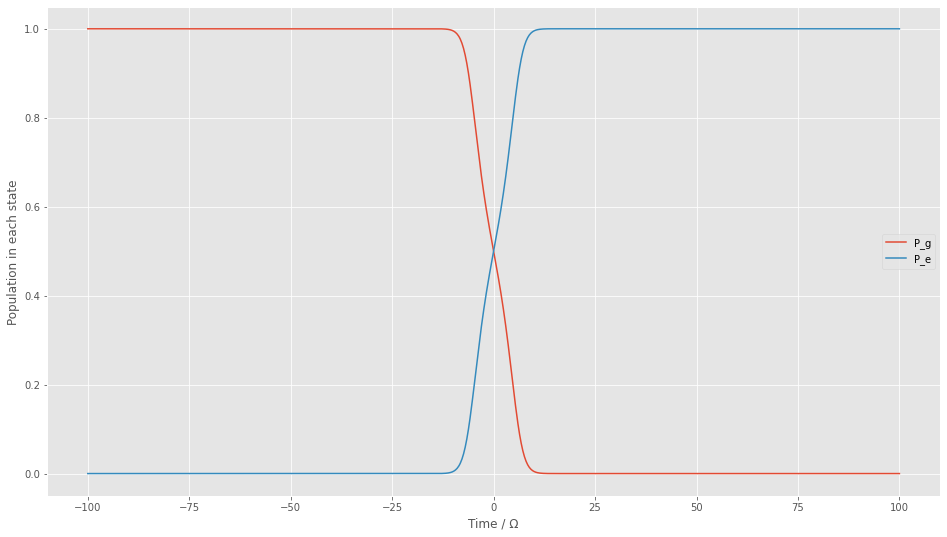

In [16]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_g")
ax.plot(times, result.expect[1], label = "P_e")
ax.legend()
ax.set_xlabel("Time / Ω")
ax.set_ylabel("Population in each state")

## What does rapid mean?
Rapid and adiabatic usually don't go well together. Adiabatic, as mentioned earlier, refers to satisfying the condition $\Omega^2/\frac{dD}{dt} >> 1$ which basically says the detuning should change slowly enough compared to the Rabi rate. The "rapid" in "Rapid adiabatic passage" actually refers to being quick compared to the lifetime of the excited state; if the excited state decays before the RAP is complete we don't get the desired population inversion.

 Total run time:   0.91s*] Elapsed 0.91s / Remaining 00:00:00:00


Text(0, 0.5, 'Population in each state')

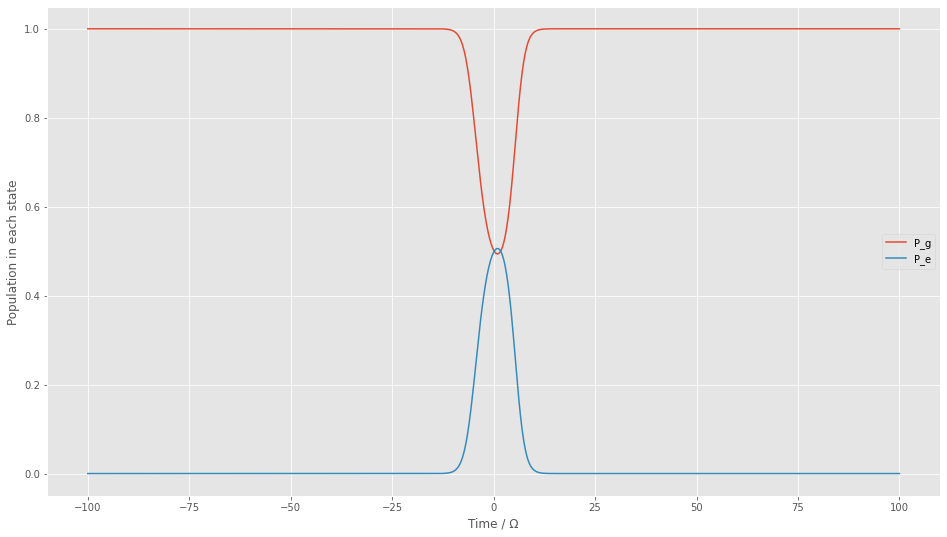

In [11]:
# Generate a Qobj representing the initial state
psi0 = (1*g).qobj(basis)

# Make operators for getting the probability of being in each state
P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")

# Set the parameters for the system
H.qobj.args["Delta"] = 1
H.qobj.args["sigma"] = 5
H.qobj.args["Omega"] = 5


times = np.linspace(-100,100,1001) # Times at which result is requested

# The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
# mitigate this 
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(H.qobj, psi0, times, c_ops = decay.qobj(gamma = 1), e_ops = [P_g_op, P_e_op], # Can vary gamma here
                      progress_bar=pb, options = options)

# Plot the result
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_g")
ax.plot(times, result.expect[1], label = "P_e")
ax.legend()
ax.set_xlabel("Time / Ω")
ax.set_ylabel("Population in each state")